In [1]:
# Cell 1: Setup and imports
import sys
sys.path.append('..')

import json
import pandas as pd
import time
from src.pipeline.baseline import SimilarityPipeline

print("Imports successful")

Imports successful


In [2]:
# Cell 2: Load arXiv data (we'll start with 10K for speed)
print("Loading arXiv abstracts...")

data_path = '../data/arxiv_100k_abstracts.json'
documents = []

with open(data_path, 'r') as f:
    for i, line in enumerate(f):
        if i >= 10_000:  # Start with 10K for faster testing
            break
        record = json.loads(line)
        documents.append({
            'id': record['id'],
            'text': record['abstract']  # Using abstract only for now
        })

print(f"Loaded {len(documents):,} documents")
print(f"\nSample document:")
print(f"ID: {documents[0]['id']}")
print(f"Text: {documents[0]['text'][:200]}...")

Loading arXiv abstracts...
Loaded 10,000 documents

Sample document:
ID: 0704.0001
Text: A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contribution...


In [3]:
# Cell 3: Create and benchmark the pipeline
print("Creating similarity pipeline...")

pipeline = SimilarityPipeline(
    num_hashes=128,
    num_bands=16,
    preprocessing_method="char_shingles",
    shingle_size=3
)

print(f"Configuration: {pipeline.get_stats()}")

# Measure indexing time
print(f"\nIndexing {len(documents):,} documents...")
start_time = time.time()

pipeline.index_documents(documents)

index_time = time.time() - start_time
docs_per_sec = len(documents) / index_time

print(f"\nIndexing complete!")
print(f"  Total time: {index_time:.2f} seconds")
print(f"  Throughput: {docs_per_sec:.0f} docs/second")

Creating similarity pipeline...
Configuration: {'num_documents': 0, 'num_hashes': 128, 'preprocessing_method': 'char_shingles', 'shingle_size': 3}

Indexing 10,000 documents...
Indexing 10000 documents...
  Indexed 1,000 documents...
  Indexed 2,000 documents...
  Indexed 3,000 documents...
  Indexed 4,000 documents...
  Indexed 5,000 documents...
  Indexed 6,000 documents...
  Indexed 7,000 documents...
  Indexed 8,000 documents...
  Indexed 9,000 documents...
  Indexed 10,000 documents...
Indexed 10,000 documents

Indexing complete!
  Total time: 2478.50 seconds
  Throughput: 4 docs/second


In [6]:
# Cell 4: Test query - find papers similar to a random abstract
import random

# Pick a random document as query
query_doc = random.choice(documents)
query_id = query_doc['id']
query_text = query_doc['text']

print(f"Query document: {query_id}")
print(f"Abstract: {query_text[:300]}...\n")

# Measure query time
print("Searching for similar documents...")
start_time = time.time()

results = pipeline.query(query_text, top_k=10, threshold=0.3)

query_time = time.time() - start_time

print(f"\nQuery complete in {query_time*1000:.2f} ms")
print(f"\nTop 10 similar documents:")
print("-" * 80)

for i, (doc_id, similarity) in enumerate(results, 1):
    print(f"\n{i}. {doc_id} (similarity: {similarity:.3f})")
    print(f"   {pipeline.documents[doc_id][:150]}...")

Query document: 0705.0867
Abstract: Random walks on expander graphs were thoroughly studied, with the important motivation that, under some natural conditions, these walks mix quickly and provide an efficient method of sampling the vertices of a graph. Alon, Benjamini, Lubetzky and Sodin studied non-backtracking random walks on regula...

Searching for similar documents...

Query complete in 218.71 ms

Top 10 similar documents:
--------------------------------------------------------------------------------

1. 0705.0867 (similarity: 1.000)
   Random walks on expander graphs were thoroughly studied, with the important motivation that, under some natural conditions, these walks mix quickly an...

2. 0704.3014 (similarity: 0.352)
   Transport properties of ultrasmall quantum dots with a single unpaired electron are commonly modeled by the nonequilibrium Kondo model, describing the...

3. 0705.0677 (similarity: 0.352)
   The Positive Mass Conjecture states that any complete asymptotically

In [7]:
# Cell 5: Test with a specific query about machine learning
ml_query = """
We present a novel deep learning approach for image classification using 
convolutional neural networks. Our method achieves state-of-the-art results 
on standard benchmarks through innovative architectural improvements.
"""

print("Query: Machine Learning / Deep Learning paper")
print(f"Text: {ml_query.strip()}\n")

results = pipeline.query(ml_query, top_k=5, threshold=0.2)

print(f"Found {len(results)} similar papers:\n")

for i, (doc_id, similarity) in enumerate(results, 1):
    print(f"{i}. {doc_id} (similarity: {similarity:.3f})")
    print(f"   {pipeline.documents[doc_id][:200]}...")
    print()

Query: Machine Learning / Deep Learning paper
Text: We present a novel deep learning approach for image classification using 
convolutional neural networks. Our method achieves state-of-the-art results 
on standard benchmarks through innovative architectural improvements.

Found 26 similar papers:

1. 0706.1066 (similarity: 0.227)
   Realizing test scenarios through a tutoring system involve questions about architecture and didactic methods in such a system. Observing the fact that traditional tutoring systems normally are domain-...

2. 0704.1890 (similarity: 0.219)
   We present a method of computing Casimir forces for arbitrary geometries, with any desired accuracy, that can directly exploit the efficiency of standard numerical-electromagnetism techniques. Using t...

3. 0704.3504 (similarity: 0.219)
   We prove that the average smooth Renyi entropy rate will approach the entropy rate of a stationary, ergodic information source, which is equal to the Shannon entropy rate for a class

Sampling similarity scores from 5 random queries...
  Query 1: 10000 results
  Query 2: 10000 results
  Query 3: 10000 results
  Query 4: 10000 results
  Query 5: 10000 results

Total similarity scores collected: 50000


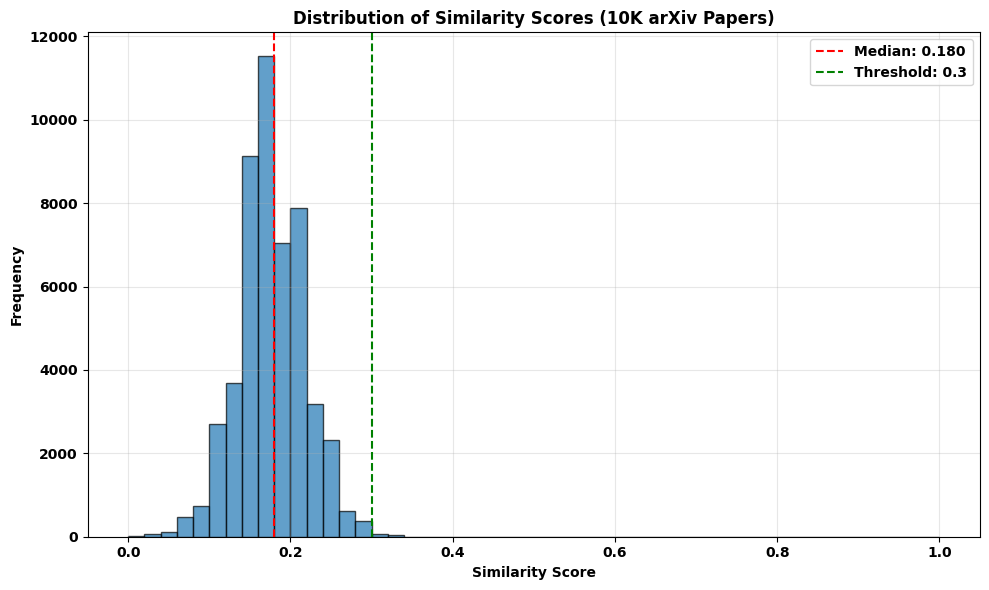


✓ Saved plot to docs/similarity_distribution_10k.png


In [11]:
# Cell 6: Analyze similarity distribution
import matplotlib.pyplot as plt
import numpy as np

# Pick 5 random queries and collect all similarity scores
all_similarities = []

print("Sampling similarity scores from 5 random queries...")
for i in range(5):
    query_doc = random.choice(documents)
    results = pipeline.query(query_doc['text'], top_k=100, threshold=0.0)
    similarities = [score for _, score in results]
    all_similarities.extend(similarities)
    print(f"  Query {i+1}: {len(similarities)} results")

print(f"\nTotal similarity scores collected: {len(all_similarities)}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(all_similarities, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores (10K arXiv Papers)')
plt.axvline(np.median(all_similarities), color='red', linestyle='--', 
            label=f'Median: {np.median(all_similarities):.3f}')
plt.axvline(0.3, color='green', linestyle='--', label='Threshold: 0.3')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../docs/similarity_distribution_10k.png', dpi=150)
plt.show()

print(f"\n✓ Saved plot to docs/similarity_distribution_10k.png")

In [12]:
# Cell 7: Performance summary
print("=" * 80)
print("BASELINE PERFORMANCE SUMMARY (10K documents)")
print("=" * 80)
print(f"Configuration:")
print(f"  - Method: {pipeline.preprocessing_method}")
print(f"  - Shingle size: {pipeline.shingle_size}")
print(f"  - MinHash signatures: {pipeline.minhash.num_hashes}")
print(f"\nIndexing:")
print(f"  - Total documents: {len(documents):,}")
print(f"  - Indexing time: {index_time:.2f} seconds")
print(f"  - Throughput: {docs_per_sec:.0f} docs/second")
print(f"\nQuerying:")
print(f"  - Query latency: {query_time*1000:.2f} ms")
print(f"  - Similarity threshold: 0.3")
print(f"\nNext steps:")
print("  - Scale to 100K documents")
print("  - Implement LSH banding for faster candidate retrieval")
print("  - Add distributed processing with Spark (Phase 2)")

BASELINE PERFORMANCE SUMMARY (10K documents)
Configuration:
  - Method: char_shingles
  - Shingle size: 3
  - MinHash signatures: 128

Indexing:
  - Total documents: 10,000
  - Indexing time: 2478.50 seconds
  - Throughput: 4 docs/second

Querying:
  - Query latency: 218.71 ms
  - Similarity threshold: 0.3

Next steps:
  - Scale to 100K documents
  - Implement LSH banding for faster candidate retrieval
  - Add distributed processing with Spark (Phase 2)
